<a href="https://colab.research.google.com/github/DonghaeSuh/NLP_Pytorch/blob/main/Model/Transformer_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 마련

In [1]:
import pandas as pd

In [2]:
ls

drive/  sample_data/


In [3]:
cd drive/MyDrive/Pytorch\ NLP/data_in/Chatbot

/content/drive/MyDrive/Pytorch NLP/data_in/Chatbot


In [4]:
ls

2_Fine_ChatbotData.csv  ChatbotData.csv       Mecab-ko-for-Google-Colab/
best_weight/            Fine_ChatbotData.csv  vocab_word.csv


In [5]:
vocab_word=pd.read_csv('vocab_word.csv')
train_data=pd.read_csv('2_Fine_ChatbotData.csv')

In [6]:
BATCH_SIZE = 2
MAX_LEN = 25
EPOCHS = 30
NUM_LAYERS = 2
FEED_WORWARD_DIM=2048

In [7]:
pip install torchtext==0.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.4 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.2
    Uninstalling torchtext-0.15.2:
      Successfully uninstalled torchtext-0.15.2


In [8]:
from torchtext import data

In [9]:
# vocab 전용
V=data.Field(sequential=True,
             use_vocab=True,
             tokenize=str.split,
             init_token='<sos>',
             eos_token='<eos>',
             fix_length=MAX_LEN)

In [10]:
Q=data.Field(sequential=True,
             use_vocab=True,
             tokenize=str.split,
             batch_first=True,
             fix_length=MAX_LEN)

A=data.Field(sequential=True,
             use_vocab=True,
             init_token='<sos>',
             eos_token='<eos>',
             tokenize=str.split,
             batch_first=True,
             fix_length=MAX_LEN)
LABEL=data.Field(sequential=True,
                 use_vocab=True,
                 eos_token='<eos>',
                 tokenize=str.split,
                 batch_first=True,
                 fix_length=MAX_LEN)

In [11]:
from torchtext.data import TabularDataset

In [12]:
train_data=TabularDataset('2_Fine_ChatbotData.csv',format='csv',fields=[('question',Q),('answer',A),('label',LABEL)],skip_header=True)
vars(train_data[0])

{'question': ['12시', '땡'],
 'answer': ['하루가', '또', '가네요'],
 'label': ['하루가', '또', '가네요']}

In [13]:
vocab_data=TabularDataset('vocab_word.csv',format='csv',fields=[('vocab_word',V)],skip_header=True)

In [14]:
V.build_vocab(vocab_data,min_freq=2)

Q.vocab=V.vocab
A.vocab=V.vocab
LABEL.vocab=V.vocab

In [15]:
import random
import torch
SEED=123
random.seed(SEED)
torch.manual_seed(SEED)

train_data,val_data=train_data.split(split_ratio=0.9,random_state=random.seed(SEED))

In [16]:
from torchtext.data import Iterator

In [17]:
train_iter=Iterator(train_data,batch_size=BATCH_SIZE)
val_iter=Iterator(val_data,batch_size=BATCH_SIZE)

In [18]:
batch=next(iter(train_iter))
batch.question

tensor([[ 742,  202, 1854, 5302,  211,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1],
        [  45,    0,    0, 2612,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1]])

In [19]:
batch.answer

tensor([[   2, 4448, 4528, 3233,  858,  321, 4934,   89,    3,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1],
        [   2,  978, 1768,  539,   89,    3,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1]])

In [20]:
batch.label

tensor([[4448, 4528, 3233,  858,  321, 4934,   89,    3,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1],
        [ 978, 1768,  539,   89,    3,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1]])

In [21]:
train_iter=Iterator(train_data,batch_size=BATCH_SIZE)
val_iter=Iterator(val_data,batch_size=BATCH_SIZE)

# 모델 구현

In [22]:
## hyperparameter
BATCH_SIZE=2
EPOCH=30
MAX_LEN=25
kargs={'max_len':MAX_LEN,
       'emb_dim':512,
       'd_model':512,
       'num_layers':2,
       'num_heads':8,
       'ffn_dim':2048,
       'vocab_size':len(V.vocab),
       'p_rate':0.1
       }

device='cuda' if torch.cuda.is_available() else 'cpu'

In [23]:
import torch
import torch.nn as nn

### positional_encoding

In [24]:
def positional_encoding(pos,d_model):
  pos=torch.arange(pos).unsqueeze(-1).to(device)
  i=torch.arange(d_model).unsqueeze(0).to(device)

  angle=pos/(torch.pow(10000,(2*i/d_model)))

  angle[:,0::2]=torch.sin(angle[:,0::2])
  angle[:,1::2]=torch.cos(angle[:,1::2])

  PE=angle.unsqueeze(0) # PE : ( 1, max_len, d_model )
  
  return PE # PE : ( 1, max_len, d_model )

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
pe=positional_encoding(25,512)

plt.pcolormesh(pe[0],cmap='RdBu')
plt.xlabel('emb_dim')
plt.ylabel('max_len')
plt.colorbar()
plt.show

### 테스트

In [ ]:
a=torch.arange(5).unsqueeze(dim=-1) # position
b=torch.arange(10).unsqueeze(dim=0)
print(a)
print(b)
a*b

In [ ]:
a=torch.Tensor([[2,3,1],[4,1,1]])
mask=torch.ones(a.size())
mask=(a==mask)*-1e9
mask

tensor([[-0.0000e+00, -0.0000e+00, -1.0000e+09],
        [-0.0000e+00, -1.0000e+09, -1.0000e+09]])

In [ ]:
print(mask[:,None,None,:],mask[:,None,None,:].size())

tensor([[[[-0.0000e+00, -0.0000e+00, -1.0000e+09]]],


        [[[-0.0000e+00, -1.0000e+09, -1.0000e+09]]]]) torch.Size([2, 1, 1, 3])


In [ ]:
a=torch.Tensor([[[1,2,3],[4,5,6]],[[3,2,1],[6,5,4]]])
b=torch.Tensor([[[-1,-1,-1]],[[1,1,1]]])
a+b

tensor([[[0., 1., 2.],
         [3., 4., 5.]],

        [[4., 3., 2.],
         [7., 6., 5.]]])

In [ ]:
a=torch.Tensor([False,True,True])
b=torch.Tensor([False,False,True])
torch.maximum(a,b)

tensor([0., 1., 1.])

### padding mask

In [25]:
def padding_mask(inp):
  # inp : ( batch_size, max_len ) 
  # padding mask
  mask=torch.ones(inp.size()).to(device)  # ( batch_size, max_len ) 
  mask=(inp==mask)*-1e9  # ( batch_size, max_len ) 
  padding_mask=mask[:,None,None,:] # ( batch_size, 1, 1, max_len )
  
  return padding_mask # ( batch_size, 1, 1, max_len )

In [74]:
padding_mask(torch.Tensor([[4,2,3,4,1,1]]))

tensor([[[[-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -1.0000e+09,
           -1.0000e+09]]]])

### 테스트

In [ ]:
a=torch.ones(4,4)
print(a.triu(diagonal=0))
print(a.triu(diagonal=1)) # 이게 필요
print(a.triu(diagonal=-1))
c=a.triu(diagonal=1)
print(c.repeat(2,1,1,1).size())
c.repeat(2,1,1,1)

tensor([[1., 1., 1., 1.],
        [0., 1., 1., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.]])
tensor([[0., 1., 1., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.]])
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [0., 1., 1., 1.],
        [0., 0., 1., 1.]])
torch.Size([2, 1, 4, 4])


tensor([[[[0., 1., 1., 1.],
          [0., 0., 1., 1.],
          [0., 0., 0., 1.],
          [0., 0., 0., 0.]]],


        [[[0., 1., 1., 1.],
          [0., 0., 1., 1.],
          [0., 0., 0., 1.],
          [0., 0., 0., 0.]]]])

In [ ]:
a=a.triu(diagonal=1)
b=torch.Tensor([[0,0,1,1]])
torch.maximum(a,b)

tensor([[0., 1., 1., 1.],
        [0., 0., 1., 1.],
        [0., 0., 1., 1.],
        [0., 0., 1., 1.]])

In [ ]:
look_ahead_mask(torch.Tensor([[4,2,3,1,1],[1,2,3,2,1]]))

tensor([[[[-0.0000e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
          [-0.0000e+00, -0.0000e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09],
          [-0.0000e+00, -0.0000e+00, -0.0000e+00, -1.0000e+09, -1.0000e+09],
          [-0.0000e+00, -0.0000e+00, -0.0000e+00, -1.0000e+09, -1.0000e+09],
          [-0.0000e+00, -0.0000e+00, -0.0000e+00, -1.0000e+09, -1.0000e+09]]],


        [[[-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
          [-1.0000e+09, -0.0000e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09],
          [-1.0000e+09, -0.0000e+00, -0.0000e+00, -1.0000e+09, -1.0000e+09],
          [-1.0000e+09, -0.0000e+00, -0.0000e+00, -0.0000e+00, -1.0000e+09],
          [-1.0000e+09, -0.0000e+00, -0.0000e+00, -0.0000e+00, -1.0000e+09]]]])

### look_ahead_mask

In [26]:
def look_ahead_mask(tar):
  # tar : ( batch_size, max_len )

  # padding mask (padding 부분이 True,  아닌 부분이 False인 요소로 채워진 Tensor)
  mask=torch.ones(tar.size()).to(device)  # ( batch_size, max_len ) 

  padding_mask=(tar==mask)  # ( batch_size, max_len ) 
  padding_mask=padding_mask[:,None,None,:] # ( batch_size, 1, 1, max_len )

  # look_ahead mask
  ones=torch.ones(tar.size()[1],tar.size()[1]).to(device) # ( max_len, max_len )
  look_ahead_mask=ones.triu(diagonal=1).to(device) # ( max_len, max_len )
  look_ahead_mask=look_ahead_mask.repeat(tar.size()[0],1,1,1) # ( batch_size, 1, ,max_len, max_len )

  look_ahead_mask=torch.maximum(padding_mask,look_ahead_mask)*-1e9
  
  return look_ahead_mask # ( batch_size, 1, ,max_len, max_len )

### 테스트

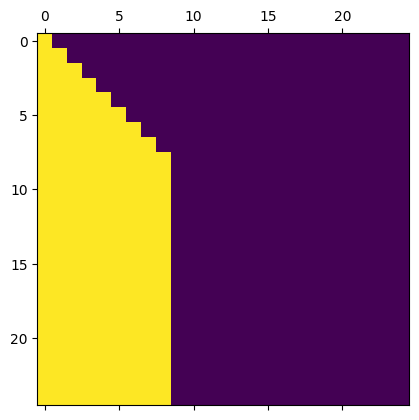

In [ ]:
plt.matshow(look_ahead_mask(batch.answer)[0][0]) # 이를 표현할 때에는 .to(device)를 모두 제거해야 한다.

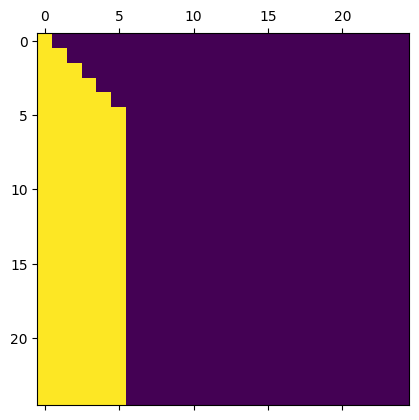

In [ ]:
plt.matshow(look_ahead_mask(batch.answer)[1][0]) # 이를 표현할 때에는 .to(device)를 모두 제거해야 한다.

### Multi-head Attention
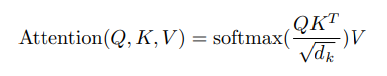

In [27]:
import math

In [116]:
class MultiheadAttention(nn.Module):
  def __init__(self,**kargs):
    super(MultiheadAttention,self).__init__()

    self.num_head=kargs['num_heads']
    self.d_model=kargs['emb_dim']
    self.depth=int(self.d_model/self.num_head)  # d_model%num_head=0

    self.wq=nn.Linear(kargs['d_model'],kargs['d_model'])
    self.wk=nn.Linear(kargs['d_model'],kargs['d_model'])
    self.wv=nn.Linear(kargs['d_model'],kargs['d_model'])

    self.final_Linear=nn.Linear(kargs['d_model'],kargs['d_model'])

    self.softmax=nn.Softmax(dim=-1)

  def split_head(self,x): # x : ( batch_size, max_len, emb_dim )
    x = x.reshape( x.size()[0] , -1, self.num_head , self.depth ) 
    # ( batch_size, max_len, num_head, depth ) # num_head*depth=emb_dim

    return x.permute(0,2,1,3) # ( batch_size, num_head, max_len, depth )

  def forward(self,q,k,v,mask):
    # q,k,v = ( batch_size, max_len, emb_dim )
    # mask = ( batch_size, 1, 1, max_len ) or ( batch_size, 1, max_len, max_len )

    q = self.wq(q) # ( batch_size, max_len, emb_dim )
    k = self.wk(k) # ( batch_size, max_len, emb_dim )
    v = self.wv(v) # ( batch_size, max_len, emb_dim )

    root_dk=math.sqrt(k.size()[-1]) 

    # split by head
    q=self.split_head(q) # ( batch_size, num_head, max_len, depth )
    k=self.split_head(k) # ( batch_size, num_head, max_len, depth )
    v=self.split_head(v) # ( batch_size, num_head, max_len, depth )

    # scaled Dot-Product Attention
    score=torch.matmul(q, k.transpose(2,3))/root_dk # ( batch_size, num_haed, max_len, max_len )
    masked_score = score+mask # ( batch_size, num_haed, max_len, max_len )
    attention = torch.matmul(self.softmax(masked_score), v ) # ( batch_size, num_haed, max_len, depth )

    # Concat and Linear
    pre_permute = attention.permute(0,2,1,3) # ( batch_size, max_len, num_head, depth )
    z = pre_permute.reshape(pre_permute.size()[0],-1,self.d_model) # ( batch_size, max_len, emb_dim )
    z = self.final_Linear(z)

    return z, attention # ( batch_size, max_len, emb_dim )  <= q,k,v of next Encoder / attetion weigth : ( batch_size, num_haed, max_len, depth )

### 테스트

In [ ]:
a=torch.Tensor([[[1,2,3,4],[4,5,6,7]],[[7,8,9,10],[10,11,12,13]]])
print(a,a.size(),sep='\n')
b=a.view(2,-1,2,2)
print(b,b.size(),sep='\n')
c=b.permute(0,2,1,3)
print(c,c.size(),sep='\n')

tensor([[[ 1.,  2.,  3.,  4.],
         [ 4.,  5.,  6.,  7.]],

        [[ 7.,  8.,  9., 10.],
         [10., 11., 12., 13.]]])
torch.Size([2, 2, 4])
tensor([[[[ 1.,  2.],
          [ 3.,  4.]],

         [[ 4.,  5.],
          [ 6.,  7.]]],


        [[[ 7.,  8.],
          [ 9., 10.]],

         [[10., 11.],
          [12., 13.]]]])
torch.Size([2, 2, 2, 2])
tensor([[[[ 1.,  2.],
          [ 4.,  5.]],

         [[ 3.,  4.],
          [ 6.,  7.]]],


        [[[ 7.,  8.],
          [10., 11.]],

         [[ 9., 10.],
          [12., 13.]]]])
torch.Size([2, 2, 2, 2])


In [ ]:
d=c.permute(0,2,1,3)
print(d,d.size(),sep='\n')
e=d.view(d.size()[0],-1,4)
print(e,e.size(),sep='\n')

tensor([[[[ 1.,  2.],
          [ 3.,  4.]],

         [[ 4.,  5.],
          [ 6.,  7.]]],


        [[[ 7.,  8.],
          [ 9., 10.]],

         [[10., 11.],
          [12., 13.]]]])
torch.Size([2, 2, 2, 2])
tensor([[[ 1.,  2.,  3.,  4.],
         [ 4.,  5.,  6.,  7.]],

        [[ 7.,  8.,  9., 10.],
         [10., 11., 12., 13.]]])
torch.Size([2, 2, 4])


In [ ]:
c.transpose(2,3)/10

tensor([[[[0.1000, 0.4000],
          [0.2000, 0.5000]],

         [[0.3000, 0.6000],
          [0.4000, 0.7000]]],


        [[[0.7000, 1.0000],
          [0.8000, 1.1000]],

         [[0.9000, 1.2000],
          [1.0000, 1.3000]]]])

### Feed Forward Network

In [29]:
def FeedForward(**kargs):
    return nn.Sequential(nn.Linear(kargs['d_model'],kargs['ffn_dim']),
                         nn.ReLU(),
                         nn.Linear(kargs['ffn_dim'],kargs['d_model'])).to(device) # ( batch_size, max_len, emb_dim )

## Encoder

### Encoder Layer

In [30]:
class EncoderLayer(nn.Module):
  def __init__(self,**kargs):
    super(EncoderLayer,self).__init__()

    self.mha=MultiheadAttention(**kargs).to(device)
    self.ffn=FeedForward(**kargs)

    self.Norm1=nn.LayerNorm(kargs['d_model'],eps=1e-6)
    self.Norm2=nn.LayerNorm(kargs['d_model'],eps=1e-6)

    self.dropout1=nn.Dropout(kargs['p_rate'])
    self.dropout2=nn.Dropout(kargs['p_rate'])

  def forward(self,x,mask):
    # x = ( batch_size, max_len, emb_dim )
    # mask = ( batch_size, 1, 1, max_len ) or ( batch_size, 1, max_len, max_len )

    # multi-head attention  # ( batch_size, max_len, emb_dim )
    post_mha,_=self.mha(x,x,x,mask) 
    post_mha=self.dropout1(post_mha)
    post_add_norm=self.Norm1(x+post_mha) # Add&Norm  # ( batch_size, max_len, emb_dim )

    # feed forward network
    post_ffn = self.ffn(post_add_norm) # ( batch_size, max_len, emb_dim )
    post_ffn = self.dropout2(post_ffn)
    output = self.Norm2(post_add_norm+post_ffn) # ( batch_size, max_len, emb_dim )
    
    return output # ( batch_size, max_len, emb_dim ) 

### Encoder

In [31]:
class Encoder(nn.Module):
  def __init__(self,**kargs):
    super(Encoder,self).__init__()
    self.embedding=nn.Embedding(kargs['vocab_size'],kargs['emb_dim'])
    self.pe=positional_encoding(kargs['max_len'],kargs['emb_dim']) # PE : ( 1, max_len, d_model )
    self.dropout=nn.Dropout(kargs['p_rate'])

    self.enc_layer=[ EncoderLayer(**kargs).to(device) for _ in range(kargs['num_layers']) ]

  def forward(self,inp,mask):
      # inp = ( batch_size, max_len )
      # mask = ( batch_size, 1, 1, max_len ) or ( batch_size, 1, max_len, max_len )
      post_emb = self.embedding(inp) # ( batch_size, max_len, emb_dim )
      post_emb*=math.sqrt(kargs['d_model'])
      x=post_emb+self.pe # ( batch_size, max_len, emb_dim )

      for i in range(kargs['num_layers']):
        x= self.enc_layer[i](x,mask)  # ( batch_size, max_len, emb_dim )

      return x # ( batch_size, max_len, emb_dim )

## Decoder

### DecoderLayer

In [32]:
class DecoderLayer(nn.Module):
  def __init__(self,**kargs):
    super(DecoderLayer,self).__init__()
    self.m_mha = MultiheadAttention(**kargs)
    self.mha = MultiheadAttention(**kargs)

    self.ffn = FeedForward(**kargs)

    self.Norm1 = nn.LayerNorm(kargs['d_model'],eps=1e-6)
    self.Norm2 = nn.LayerNorm(kargs['d_model'],eps=1e-6)
    self.Norm3 = nn.LayerNorm(kargs['d_model'],eps=1e-6)

    self.dropout1 = nn.Dropout(kargs['p_rate'])
    self.dropout2 = nn.Dropout(kargs['p_rate'])
    self.dropout3 = nn.Dropout(kargs['p_rate'])

  def forward(self,dec_input, enc_output, look_ahead_mask,padding_mask):
    # x : ( batch_size, max_len, emb_dim )
    # look_ahead_mask : ( batch_size, 1, max_len, max_len )
    # padding_mask : ( batch_size, 1, 1, max_len )

    # masked_multi-head attention
    post_m_mha, attention_weight_block1= self.m_mha(dec_input, dec_input, dec_input, look_ahead_mask) 
    # ( batch_size, max_len, emb_dim ) / attetion weigth : ( batch_size, num_haed, max_len, depth )
    post_m_mha = self.dropout1(post_m_mha) # ( batch_size, max_len, emb_dim )
    out1= self.Norm1(dec_input+post_m_mha) # ( batch_size, max_len, emb_dim )

    # multi-haed attetnion
    post_mha, attention_weight_block2 = self.mha(out1, enc_output, enc_output, padding_mask )  
    # ( batch_size, max_len, emb_dim ) / attetion weigth : ( batch_size, num_haed, max_len, depth )
    post_mha = self.dropout2(post_mha)  # ( batch_size, max_len, emb_dim )
    out2 = self.Norm2(out1+post_mha)  # ( batch_size, max_len, emb_dim )

    # feed forward network
    post_ffn = self.ffn(out2) # ( batch_size, max_len, emb_dim )
    out3 = self.Norm3(out2+post_ffn) # ( batch_size, max_len, emb_dim )

    return out3 , attention_weight_block1, attention_weight_block2 
    # ( batch_size, max_len, emb_dim ) / attetion weigth : ( batch_size, num_haed, max_len, depth )

### Decoder

In [33]:
class Decoder(nn.Module):
  def __init__(self,**kargs):
    super(Decoder,self).__init__()
    
    self.embedding = nn.Embedding(kargs['vocab_size'],kargs['emb_dim'])
    self.pe = positional_encoding(kargs['max_len'],kargs['d_model'])

    self.dec_layer = [DecoderLayer(**kargs).to(device) for _ in range(kargs['num_layers'])]

    self.dropout = nn.Dropout(kargs['p_rate'])

  def forward(self,dec_input, enc_output, look_ahead_mask, padding_mask ):
    # dec_input : ( batch_size, max_len, emb_dim )
    # enc_output : ( batch_size, max_len, emb_dim )
    # look_ahead_mask : ( batch_size, 1, max_len, max_len )
    # padding_mask : ( batch_size, 1, 1, max_len )

    attention_weights = {}
    seq_len = dec_input.size()[1]

    post_emb = self.embedding(dec_input) # ( batch_size, max_len, emb_dim )
    post_emb*=math.sqrt(kargs['d_model']) # scaling , ( batch_size, max_len, emb_dim )
    post_emb+=self.pe[:,:seq_len, :] # ( batch_size, max_len, emb_dim )
    output = self.dropout(post_emb) # ( batch_size, max_len, emb_dim )


    for i in range(kargs['num_layers']):
      output, block1, block2 = self.dec_layer[i](output, enc_output, look_ahead_mask, padding_mask) 
      # ( batch_size, max_len, emb_dim ) / attetion weigth_block : ( batch_size, num_haed, max_len, depth )
      attention_weights['decoder_layer{}_block1'.format(i+1)]=block1
      attention_weights['decoder_layer{}_block2'.format(i+1)]=block2

    return output, attention_weights
    # ( batch_size, max_len, emb_dim )
    # attention_weights : 각 layer의 mha block의 attention 가중치가 value로 담겨있는 사전

## Transformer

In [114]:
class Transformer(nn.Module):
  def __init__(self,**kargs):
    super(Transformer,self).__init__()
    self.encoder = Encoder(**kargs)
    self.decoder = Decoder(**kargs)

    self.final_Linear = nn.Linear(kargs['emb_dim'],kargs['vocab_size'])

  def forward(self,inp,tar):
    # inp : ( batch_size, max_len )
    # tar : ( batch_size, max_len )
    # look_ahead_mask : ( batch_size, 1, max_len, max_len )
    # padding_mask : ( batch_size, 1, 1, max_len )

    # create mask
    inp_mask = padding_mask(inp) # padding_mask : ( batch_size, 1, 1, max_len )
    tar_mask1 = look_ahead_mask(tar)  # look_ahead_mask : ( batch_size, 1, max_len, max_len )
    tar_mask2 = padding_mask(tar) # padding_mask : ( batch_size, 1, 1, max_len )

    # encoder
    enc_output = self.encoder(inp,inp_mask) # ( batch_size, max_len, emb_dim )

    # decoder
    dec_output,_ = self.decoder(tar, enc_output, tar_mask1, tar_mask2) # ( batch_size, max_len, emb_dim )
    
    # Linear
    output = self.final_Linear(dec_output) # ( batch_size, max_len, vocab_size )
    output = output.transpose(1,2) # ( batch_size, vocab_size, max_len )

    return output # ( batch_size, vocab_size, max_len )

  def inference(self,inp,max_ans_len):
    # inp : ( 1, max_len )
    inp_mask = padding_mask(inp) # padding_mask : ( 1, 1, 1, max_len )
    enc_output = self.encoder(inp,inp_mask) # ( 1, max_len, emb_size )

    tar=[[V.vocab.stoi['<sos>']]+[V.vocab.stoi['<pad>']]*(kargs['max_len']-1)]
    tar = torch.LongTensor(tar).to(device) # ( 1, max_len )

    predict=list()

    for t in range(max_ans_len):
      tar_mask1 = look_ahead_mask(tar)  # look_ahead_mask : ( 1, 1, 25, 25 )
      tar_mask2 = padding_mask(tar) # padding_mask : ( 1, 1, 1, 25 )
      dec_output,_ = self.decoder(tar,enc_output,tar_mask1,tar_mask2) # ( 1, 25, emb_dim )
      output = self.final_Linear(dec_output) # ( 1, 25, vocab_size)
      
      predict.append(int(torch.argmax(output,-1)[0][t])) 
      if predict[-1]==V.vocab.stoi['<eos>']:
        break
      tar=[[V.vocab.stoi['<sos>']]+predict+[V.vocab.stoi['<pad>']]*(kargs['max_len']-(t+2))] # ( 1, max_len )
      tar = torch.LongTensor(tar).to(device)

    return predict[:-1] # ( 답변 길이, ) # 맨 마지막 <eos> 제거

### 테스트

In [ ]:
torch.Tensor([V.vocab.stoi['<sos>']])

tensor([2.])

In [80]:
a=torch.Tensor([[2,5]])
b=torch.Tensor([[5,7]])[:,-1]
c=torch.cat([a,b[None,:]],-1)
print(c)
padding_mask(c).size()

tensor([[2., 5., 7.]])


torch.Size([1, 1, 1, 3])

In [ ]:
a=torch.Tensor([[[1,2,3,4,5,4,3,2,1],[1,2,3,4,5,4,3,2,8]]])
b=torch.argmax(a,-1)[:,-1]
if b==8:
  print('그래')

그래


In [94]:
tar=[[V.vocab.stoi['<sos>']]+[V.vocab.stoi['<pad>']]*(kargs['max_len']-1)]
torch.LongTensor(tar)

tensor([[2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1]])

In [103]:
a=torch.Tensor([[[1,2,3,4,5,4,3,2,1],[1,2,3,4,5,4,3,2,8]]])
int(torch.argmax(a,-1)[0][1])

8

# Train

In [35]:
## hyperparameter
BATCH_SIZE=2
EPOCH=30
MAX_LEN=25
kargs={'max_len':MAX_LEN,
       'emb_dim':512,
       'd_model':512,
       'num_layers':2,
       'num_heads':8,
       'ffn_dim':2048,
       'vocab_size':len(V.vocab),
       'p_rate':0.1
       }

device='cuda' if torch.cuda.is_available() else 'cpu'

### Compile

In [117]:
model = Transformer(**kargs).to(device)
optimizer = torch.optim.Adam(model.parameters(),1e-4)
criterion = nn.CrossEntropyLoss(reduction='none',ignore_index=0)

## Train

In [37]:
from tqdm import tqdm

In [38]:
def loss_padding(predict,label):
  # 패딩을 loss 계산에서 지울 것이다. => label에서 index가 1인 부분에 대한 mask를 생성해서 곱해주자 / 추가적으로 accuracy 계산에서도 사용할 mask를 반환
    mask=torch.ones(predict.size()).to(device)
    mask=torch.logical_not(mask==label)
    
    return ((predict*mask).sum())/mask.sum()

### 테스트

In [39]:
output=model(batch.question.to(device),batch.answer.to(device))
print(output.size())
loss=criterion(output,batch.label.to(device))
print(loss)
loss_padding(loss,batch.answer.to(device))

torch.Size([2, 9470, 25])
tensor([[ 9.1000,  9.7201,  8.8066,  9.6515,  9.1926,  9.5787,  9.5513, 10.4012,
         10.0843,  8.6300,  8.9856,  9.3027,  8.9867,  9.1168,  8.4909,  8.7824,
          8.5005,  8.9317,  9.1824,  8.5907,  8.9038,  8.5376,  8.8263,  8.9623,
          8.5800],
        [ 9.9087,  9.9234,  9.5817,  9.2101, 10.4605, 10.3115,  8.8544,  8.7652,
          9.0175,  8.7727,  8.7922,  8.7394,  8.5367,  8.5548,  8.9932,  8.8722,
          8.6833,  8.6966,  8.8398,  9.2897,  8.6282,  8.6513,  8.8600,  8.6779,
          8.6033]], grad_fn=<ViewBackward0>)


tensor(9.6988, grad_fn=<DivBackward0>)

## train

In [40]:
def train(model,optimizer,criterion,train_iter):
  model.train()

  for batch in tqdm(train_iter):
    enc_input=batch.question.to(device)
    dec_input=batch.answer.to(device)
    label=batch.label.to(device)

    loss=model(enc_input,dec_input) # ( batch_size, vocab_size, max_len )
    loss= loss_padding(criterion(loss,label),label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

## Evaluation

In [41]:
def acc_padding(logit,label):
  # padding을 포함하지 않은 맞춘 개수를 반환 및 acc,loss 계산에 포함되는 전체 token 개수 return
  acc=(logit.max(2)[1]==label) # 맞춘 개수 
  print(logit.max(2)[1])
  mask=torch.ones(label.size()).to(device)
  mask=torch.logical_not(mask==label)
  acc=mask*acc # masking : padding에 해당하는 맞춘 개수는 제외

  acc=acc.sum() # 계산에 포함되는 batch내의 맞춘 token의 개수
  size=mask.sum() # 계산에 포함되는 batch내의 모든 token의 개수
  
  return acc/size

In [42]:
def evaluation(model,optimizer,criterion,val_iter):
  model.eval()

  total_loss,acc,size=0,0,0
  
  for batch in tqdm(val_iter):
    enc_input=batch.question.to(device)
    dec_input=batch.answer.to(device)
    label=batch.label.to(device)

    logit=model(enc_input,dec_input) # ( batch_size, vocab_size, max_len )
    loss = loss_padding(criterion(logit,label),label) # ( batch_size, max_len )
    total_loss+=loss

    logit=logit.transpose(1,2) # ( batch_size, max_len, vocab_size )
    acc = acc_padding(logit,label)
    acc+=acc

  avg_loss=total_loss/len(val_iter)
  avg_acc=acc/len(val_iter)

  return avg_loss, avg_acc

## Training

In [ ]:
import os

In [ ]:
best_val_loss = None

for e in range(EPOCH):
  train(model,optimizer,criterion,train_iter)
  val_loss,val_acc = evaluation(model,optimizer,criterion,val_iter)

  print("Epoch : {} | val_loss : {:5.2f} , val_accuracy : {:5.2f}".format(e+1,val_loss.item(),val_acc.item()))

  if not best_val_loss or best_val_loss>val_loss:
    os.makedirs('best_weight',exist_ok=True)
    torch.save(model.state_dict(),'./best_weight/best_performance_weight.pt')
    best_val_loss=val_loss

# Chatbot

In [43]:
import re

In [118]:
# 실제 사용
# model output ( batch_size, vocab_size, max_len==25 )

model.load_state_dict(torch.load('./best_weight/best_performance_weight.pt',map_location=torch.device('cpu')))

def chatbot(sentence):
  input=re.sub('[^ a-zA-Z0-9가-힣]',"",sentence).split()

  if len(input)<MAX_LEN:
    input=input+['<pad>']*(MAX_LEN-len(input)) # padding
  else:
    input=input[:MAX_LEN] # truncate

  input=torch.LongTensor([V.vocab.stoi[word] for word in input])[None,:].to(device) # sentence to index ( 1, max_len ) 

  predict=model.inference(input,14)

  return " ".join([V.vocab.itos[word] for word in predict][1:]) # <sos> 제거

### 테스트

In [ ]:
input=re.sub('[^ a-zA-Z0-9가-힣]',"",sentence).split()

if len(input)<MAX_LEN:
    input=input+['<pad>']*(MAX_LEN-len(input)) # padding
else:
    input=input[:MAX_LEN] # truncate

input=torch.LongTensor([V.vocab.stoi[word] for word in input])[None,:].to(device)
input

tensor([[ 184, 3340,  555, 1549, 3340,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1]], device='cuda:0')

### 사용

In [127]:
sent=input()
chatbot(sent)

안녕


'당신의 잘못이 아니에요 너무 무거운 짐을 덜어보세요'

In [128]:
sent=input()
chatbot(sent)

너는 누구니


'거예요 그러다가 이랬다 저랬다 크기가 다르겠지만 좋아하는 죽을 티나요 동료가 있을 듯'

In [129]:
sent=input()
chatbot(sent)

무슨 말을 하는 거니


'고백이 쓴 게 먼저일 짧아요 되요 있으면 피하세요'

In [130]:
sent=input()
chatbot(sent)

헛소리 하지마 임마


'겨울 나길 호감을 표현해보세요'

In [131]:
sent=input()
chatbot(sent)

알았어


'하기도 합니다'

In [132]:
sent=input()
chatbot(sent)

학습이 아직 덜 되었나 보네


'마시기 전에 두근거림을 좋아하나 봐요 곧 기운낼 수 있어요라고 감히 말해 달라고'